In [1]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.sentence as nas
from typing import List, Optional

import nltk

nltk.download("averaged_perceptron_tagger_eng")

/home/flavien/anaconda3/envs/nlp-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/flavien/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [2]:
ds = load_dataset("jniimi/tripadvisor-review-rating")
raw_data = pd.DataFrame(ds["train"])

raw_data

,hotel_id,user_id,title,text,overall,cleanliness,value,location,rooms,sleep_quality,stay_year,post_date,freq,review,char,lang
0,127781101,2262DCBFC351F42A9DD30AC8BAD24686,Really excellent Hilton,Stayed here on business trips and the hotel is...,5.0,4.0,5.0,4.0,5.0,4.0,2012,2012-04-13,1,Really excellent Hilton\nStayed here on busine...,204,__label__en
1,137380592,8477E11DABF4D6743885E401BB4C8CCF,Exceptional service and comfort,Spent two nights here for a wedding in Brookly...,5.0,5.0,4.0,5.0,4.0,5.0,2012,2012-08-16,1,Exceptional service and comfort\nSpent two nig...,621,__label__en
2,129673371,483A193B7113ADFFD5CE30849564F69C,Nice room and five star service,Great place for a 3-night stay. Our king room ...,5.0,5.0,5.0,3.0,5.0,4.0,2012,2012-05-09,1,Nice room and five star service\nGreat place f...,1259,__label__en
3,129006626,E5A63DD7239A7057746D4644A5C986EB,"BRILLIANT hotel, my #1 Chicago pick for busine...","This is my favorite hotel in Chicago, and I've...",5.0,5.0,5.0,5.0,5.0,5.0,2012,2012-04-28,1,"BRILLIANT hotel, my #1 Chicago pick for busine...",2242,__label__en
4,139168159,CBFE281C9386225267BC52518836A6C2,Convenient and comfortable,BEST. BREAKFAST. EVER. Couldn't have been happ...,5.0,5.0,4.0,5.0,4.0,5.0,2012,2012-09-02,1,Convenient and comfortable\nBEST. BREAKFAST. E...,511,__label__en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201290,135811676,F343B7C4978A928494222A63EA33259B,Great find in cool neighborhood,"Although a native NY'er, I haven't spent any t...",4.0,4.0,4.0,5.0,4.0,4.0,2012,2012-07-30,1,Great find in cool neighborhood\nAlthough a na...,1545,__label__en
201291,129553333,AF4C4D7F38A7CB053D226AE7954294B7,Exceptional Service and great room,I have stayed here a couple of times and have ...,5.0,5.0,5.0,5.0,5.0,5.0,2012,2012-05-07,1,Exceptional Service and great room\nI have sta...,230,__label__en
201292,143681514,C88ACB857117608D118C91D56F79531A,Beware of the Rip Off!,I received a call for a two day stay at the Hi...,2.0,2.0,1.0,4.0,2.0,1.0,2012,2012-10-25,1,Beware of the Rip Off!\nI received a call for ...,572,__label__en
201293,139622044,39EE66822F41168E3867C9DBED81081A,It Deserves the Rating,"I really like Kimptons. Every so often, you'll...",5.0,5.0,4.0,5.0,5.0,5.0,2012,2012-09-07,1,It Deserves the Rating\nI really like Kimptons...,746,__label__en


In [3]:
class DataAugmentation:
    """
    Class for augmenting textual data, particularly useful for balancing
    minority classes in an imbalanced dataset.
    """

    def __init__(self, random_state: int = 42):
        """
        Initializes the data augmentation class.

        Args:
            random_state: Seed for reproducibility
        """
        self.random_state = random_state
        np.random.seed(random_state)

        # Initialize augmenters
        self.augmenters = {
            "synonym": naw.SynonymAug(aug_src="wordnet"),
            "contextual": naw.ContextualWordEmbsAug(
                model_path="distilbert-base-uncased", action="substitute"
            ),
            "random": naw.RandomWordAug(action="swap"),
            "sentence_shuffle": nas.RandomSentAug(),
            "word_deletion": naw.RandomWordAug(action="delete", aug_p=0.1),
        }

    def augment_text(
        self, text: str, methods: List[str] = None, n: int = 1
    ) -> List[str]:
        """
        Augments a text using multiple methods.

        Args:
            text: The text to augment
            methods: List of augmentation methods to use
            n: Number of augmentations per method

        Returns:
            List of augmented texts
        """

        # print(f"Original text: {text}\n")
        if methods is None:
            methods = ["synonym", "random"]

        augmented_texts = []

        for method in methods:
            if method in self.augmenters:
                try:
                    augmenter = self.augmenters[method]
                    augmented = augmenter.augment(text, n=n)
                    # print(f"Augmented text using {method}:\n{augmented}\n")
                    if isinstance(augmented, str):
                        augmented = [augmented]

                    augmented_texts.extend(augmented)
                except Exception as e:
                    print(f"Error during augmentation with method {method}: {e}")

        return augmented_texts

    def balance_dataset(
        self,
        df: pd.DataFrame,
        text_col: str,
        label_col: str,
        target_counts: Optional[dict] = None,
        methods: List[str] = None,
    ) -> pd.DataFrame:
        """
        Balances a DataFrame by augmenting minority classes.

        Args:
            df: DataFrame containing the data
            text_col: Name of the column containing the text
            label_col: Name of the column containing the labels
            target_counts: Dictionary specifying the target number of samples for each class
                          (if None, all classes will be balanced to match the majority class)
            methods: Augmentation methods to use
        Returns:
            Balanced DataFrame
        """

        # Count occurrences of each class
        class_counts = df[label_col].value_counts().to_dict()
        max_count = max(class_counts.values())

        # If target_counts is not provided, set all classes to 80% of the max count
        if target_counts is None:
            target_counts = {
                label: int(max_count * 0.8) for label in class_counts.keys()
            }

        balanced_df = df.copy()

        for label, count in class_counts.items():
            target = target_counts.get(label, max_count)

            if count < target:
                # Number of samples to add
                samples_needed = target - count

                # Select samples of the current class
                class_samples = df[df[label_col] == label]

                # Calculate how many augmentations per sample
                augmentations_per_sample = int(
                    np.ceil(samples_needed / len(class_samples))
                )

                new_samples = []

                # For each sample of the minority class
                for _, row in class_samples.iterrows():
                    # Augment the text
                    augmented_texts = self.augment_text(
                        row[text_col], methods=methods, n=augmentations_per_sample
                    )

                    # Add the new augmented samples
                    for aug_text in augmented_texts[
                        : min(augmentations_per_sample, samples_needed)
                    ]:
                        new_row = row.copy()
                        new_row[text_col] = aug_text
                        new_samples.append(new_row)
                        samples_needed -= 1

                        if samples_needed <= 0:
                            break

                # Add the new samples to the DataFrame
                if new_samples:
                    balanced_df = pd.concat(
                        [balanced_df, pd.DataFrame(new_samples)], ignore_index=True
                    )
                    self.save_augmented_data(
                        pd.DataFrame(new_samples), f"augmented.csv"
                    )

        return balanced_df

    def save_augmented_data(self, df: pd.DataFrame, file_path: str):
        df.to_csv(file_path, index=False)
        print(f"Augmented data saved to {file_path}")

In [12]:
train_df = raw_data[["review", "overall"]]
train_df

,review,overall
0,Really excellent Hilton\nStayed here on busine...,5.0
1,Exceptional service and comfort\nSpent two nig...,5.0
2,Nice room and five star service\nGreat place f...,5.0
3,"BRILLIANT hotel, my #1 Chicago pick for busine...",5.0
4,Convenient and comfortable\nBEST. BREAKFAST. E...,5.0
...,...,...
201290,Great find in cool neighborhood\nAlthough a na...,4.0
201291,Exceptional Service and great room\nI have sta...,5.0
201292,Beware of the Rip Off!\nI received a call for ...,2.0
201293,It Deserves the Rating\nI really like Kimptons...,5.0


/tmp/ipykernel_9160/2610171342.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='overall', data=train_df, palette='viridis')


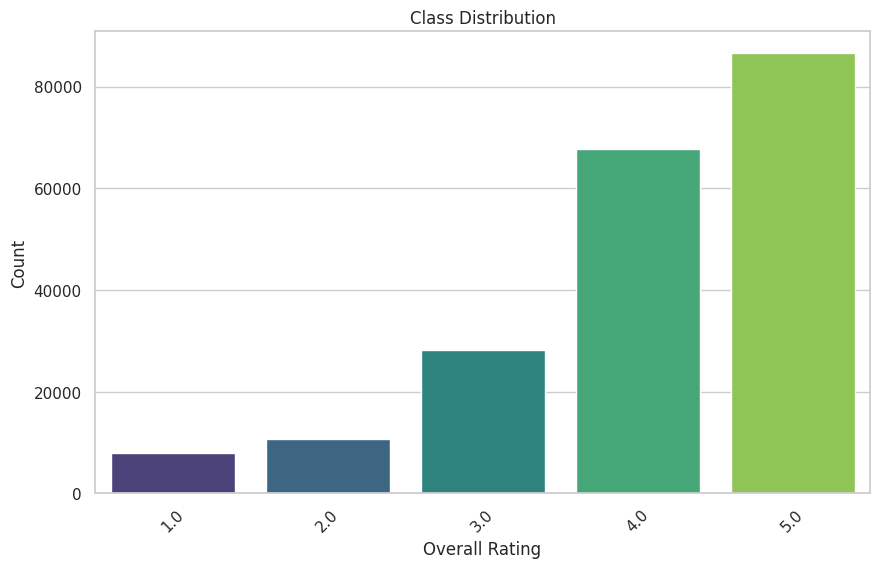

In [16]:
# Plot class distribution
import matplotlib.pyplot as plt
import seaborn as sns

train_df = raw_data[["review", "overall"]]
train_df

plt.figure(figsize=(10, 6))
sns.countplot(x="overall", data=train_df, palette="viridis")
plt.title("Class Distribution")
plt.xlabel("Overall Rating")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.savefig("class_distribution.png")

In [18]:
print("Équilibrage du jeu de données...")
# Afficher la distribution des classes avant équilibrage
print("Distribution des classes avant équilibrage:")
label_col = "overall"
print(train_df[label_col].value_counts())

# Initialiser la classe d'augmentation
augmenter = DataAugmentation(random_state=42)

# Calculer le nombre cible d'échantillons par classe
class_counts = train_df[label_col].value_counts().to_dict()
max_count = max(class_counts.values())

# Utiliser la distribution cible depuis la ou par défaut
# Par défaut, équilibrer toutes les classes à 80% de la classe majoritaire
target_counts = {label: int(max_count * 0.8) for label in class_counts}
print("Target counts:", target_counts)

# Équilibrer le jeu de données
train_df = augmenter.balance_dataset(
    train_df,
    text_col="review",
    label_col=label_col,
    target_counts=target_counts,
    methods=["sentence_shuffle", "synonym", "word_deletion"],
)

# Afficher la distribution des classes après équilibrage
print("Distribution des classes après équilibrage:")
print(train_df[label_col].value_counts())

df_augmented = train_df.copy()

Équilibrage du jeu de données...
Distribution des classes avant équilibrage:
overall
5.0    86516
4.0    67732
3.0    28216
2.0    10786
1.0     8045
Name: count, dtype: int64
Target counts: {5.0: 69212, 4.0: 69212, 3.0: 69212, 2.0: 69212, 1.0: 69212}
Augmented data saved to augmented.csv
Augmented data saved to augmented.csv
Augmented data saved to augmented.csv
Augmented data saved to augmented.csv
Distribution des classes après équilibrage:
overall
5.0    86516
4.0    69212
2.0    69212
3.0    69212
1.0    69212
Name: count, dtype: int64


/tmp/ipykernel_9160/4191270899.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='overall', data=df_augmented, palette='viridis')


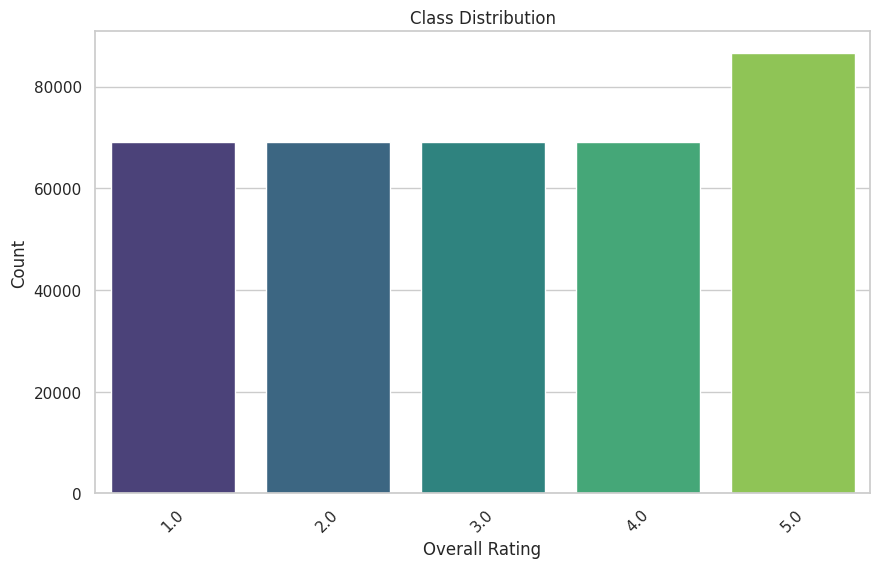

In [19]:
plt.figure(figsize=(10, 6))
sns.countplot(x="overall", data=df_augmented, palette="viridis")
plt.title("Class Distribution")
plt.xlabel("Overall Rating")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.savefig("augmented_class_distribution.png")